In [1]:
import pandas as pd
import numpy as np
import re
import nltk; nltk.download('stopwords')
from pprint import pprint

# Gensim
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

from tqdm import tqdm_notebook as tqdm

# spacy for lemmatization
import spacy

# Plotting tools
import pyLDAvis
import pyLDAvis.gensim  # don't skip this
import matplotlib.pyplot as plt
%matplotlib inline

# Enable logging for gensim - optional
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.ERROR)

import warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/erenaldis/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [180]:
#read gutenberg corpus, downloaded at path gutenberg/txt/
N_books = 200
import glob
path = 'gutenberg/txt/*.txt'
files = glob.glob(path)
np.random.shuffle(files)
corpus = {}
for file in tqdm(files[:N_books]):
    with open(file) as f:
        text = f.read()
        corpus[file] = text.split()

In [181]:
files

['gutenberg/txt/Anthony Trollope___The Relics of General Chasse.txt',
 'gutenberg/txt/William Wymark Jacobs___Made to Measure, Deep Waters, Part 3.txt',
 'gutenberg/txt/Anthony Trollope___The Mistletoe Bough.txt',
 'gutenberg/txt/William J Long___Northern Trails, Book 1.txt',
 'gutenberg/txt/D H Lawrence___Fantasia of the Unconscious.txt',
 'gutenberg/txt/Thomas Henry Huxley___The Darwinian Hypothesis.txt',
 'gutenberg/txt/William Wymark Jacobs___Over The Side, Captains All, Book 6.txt',
 'gutenberg/txt/Anthony Trollope___Miss Mackenzie.txt',
 'gutenberg/txt/Hector Hugh Munro___The Unbearable Bassington.txt',
 "gutenberg/txt/Robert Louis Stevenson___A Child's Garden of Verses, Version 4.txt",
 'gutenberg/txt/Winston Churchill___An Essay On The American Contribution And The Democratic Idea.txt',
 'gutenberg/txt/Lucy Maud Montgomery___The Golden Road.txt',
 'gutenberg/txt/William Ewart Gladstone___On Books and the Housing of Them.txt',
 'gutenberg/txt/William Wymark Jacobs___A Spirit of 

In [183]:
files

['gutenberg/txt/Anthony Trollope___The Relics of General Chasse.txt',
 'gutenberg/txt/William Wymark Jacobs___Made to Measure, Deep Waters, Part 3.txt',
 'gutenberg/txt/Anthony Trollope___The Mistletoe Bough.txt',
 'gutenberg/txt/William J Long___Northern Trails, Book 1.txt',
 'gutenberg/txt/D H Lawrence___Fantasia of the Unconscious.txt',
 'gutenberg/txt/Thomas Henry Huxley___The Darwinian Hypothesis.txt',
 'gutenberg/txt/William Wymark Jacobs___Over The Side, Captains All, Book 6.txt',
 'gutenberg/txt/Anthony Trollope___Miss Mackenzie.txt',
 'gutenberg/txt/Hector Hugh Munro___The Unbearable Bassington.txt',
 "gutenberg/txt/Robert Louis Stevenson___A Child's Garden of Verses, Version 4.txt",
 'gutenberg/txt/Winston Churchill___An Essay On The American Contribution And The Democratic Idea.txt',
 'gutenberg/txt/Lucy Maud Montgomery___The Golden Road.txt',
 'gutenberg/txt/William Ewart Gladstone___On Books and the Housing of Them.txt',
 'gutenberg/txt/William Wymark Jacobs___A Spirit of 

# Get initial statistics

In [182]:
doc_lengths = []
for k, v in tqdm(corpus.items()):
    doc_lengths.append(len(v))
print('Max length:', max(doc_lengths))
print('Min length:', min(doc_lengths))
print('Mean length:', np.mean(doc_lengths))
print('Std. length:', np.std(doc_lengths))


Max length: 280852
Min length: 1010
Mean length: 59073.645
Std. length: 46716.18140557911


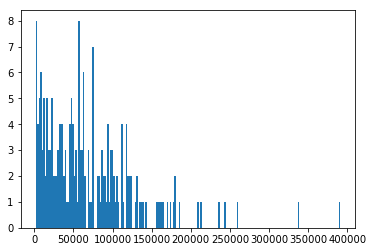

In [155]:
n, bins, patches = plt.hist(doc_lengths, bins=200)
plt.savefig('initial_hist.png')

# Preprocessing

## Preprocessing the document distributions

In [186]:
#Remove docs larger than 150000 and smaller than 2000
max_len = 150000
min_len = 2000
keys_to_pop = []
for k, v in tqdm(corpus.items()):
    if (len(v) > max_len) or (len(v) < min_len):
        keys_to_pop.append(k)
for k in tqdm(keys_to_pop):
    _ = corpus.pop(k)

New corpus length:  187


Max length: 147462
Min length: 2266
Mean length: 53588.59893048128
Std. length: 37317.366533410095


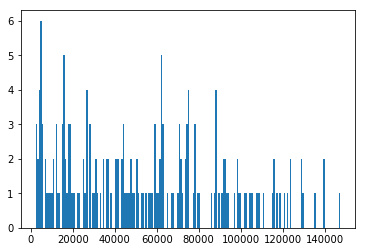

In [187]:
print('New corpus length: ', len(corpus))
doc_lengths = []
for k, v in tqdm(corpus.items()):
    doc_lengths.append(len(v))
print('Max length:', max(doc_lengths))
print('Min length:', min(doc_lengths))
print('Mean length:', np.mean(doc_lengths))
print('Std. length:', np.std(doc_lengths))

n, bins, patches = plt.hist(doc_lengths, bins=200)
plt.savefig('processed_hist.png')

## Preprocessing the individual documents using NLP

In [188]:
#use this if spacy downloaded
nlp = spacy.load('en', disable=['parser', 'ner'])
def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """https://spacy.io/api/annotation"""
    doc = nlp(" ".join(texts)) 
    texts_out = [token.lemma_ for token in doc if token.pos_ in allowed_postags]
    return texts_out

In [189]:
for k in tqdm(corpus.keys()):
    #tokenize and clean up
    cleaned_up = gensim.utils.simple_preprocess(str(corpus[k]), deacc=True)  # deacc=True removes punctuations
    
    #keep only nouns, adjectives, verbs, adverbs (remove named entities)
    lemmatized = lemmatization(cleaned_up)
    
    corpus[k] = lemmatized

## Building Bag of Words, TFIDF, Document Term Matrix

In [190]:
dictionary = gensim.corpora.Dictionary(corpus.values())

In [191]:
len(dictionary)

71365

In [192]:
#remove common words if word appears in more than 25% of docs or less than 20 docs
dictionary.filter_extremes(no_below=20, no_above=0.25, keep_n=20000)

In [193]:
#Bag of Words
bow_corpus = [dictionary.doc2bow(doc) for doc in corpus.values()]

In [194]:
#TFIDF
from gensim import models
tfidf = models.TfidfModel(bow_corpus)
corpus_tfidf = tfidf[bow_corpus]

In [195]:
#document term matrix
max_num = len(dictionary.keys())
dtm = np.zeros((len(bow_corpus), max_num))
for i in tqdm(range(len(bow_corpus))):
    for word, count in bow_corpus[i]:
        dtm[i, word] = int(count)

# Variational Bayes Based Models (BOW, TFIDF)

## BOW Model

In [204]:
Ts = [5, 10, 20, 40, 100, 400]
bound_bow = []
bow_models = []
for T in tqdm(Ts):
    bow_model = gensim.models.LdaMulticore(bow_corpus, 
                                   num_topics = T, 
                                   id2word = dictionary,                                    
                                   passes = 2,
                                   workers = 2, )
    #bow_models.append(bow_model)
#     print('For beta = ' + str(beta))
#     for idx, topic in bow_model.print_topics(-1):
#         print('Topic: {} \nWords: {}'.format(idx, topic))
    bound_bow.append(bow_model.bound(bow_corpus))

/Users/erenaldis/anaconda/lib/python3.6/site-packages/gensim/models/ldamodel.py:1024: RuntimeWarning: divide by zero encountered in log
  diff = np.log(self.expElogbeta)


In [27]:
# Visualize the topics
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(bow_model, bow_corpus, dictionary)
vis

PreparedData(topic_coordinates=            Freq  cluster  topics         x         y
topic                                                
0      26.862224        1       1  0.019769 -0.011276
4      21.749206        1       2  0.001094 -0.017780
1      19.423851        1       3 -0.019216 -0.005615
2      17.064042        1       4  0.025780  0.020400
3      14.900676        1       5 -0.027428  0.014271, topic_info=     Category         Freq       Term        Total  loglift  logprob
term                                                                
364   Default  1004.000000      henry  1004.000000  30.0000  30.0000
1364  Default   691.000000  elizabeth   691.000000  29.0000  29.0000
863   Default   428.000000     victor   428.000000  28.0000  28.0000
541   Default   479.000000      olive   479.000000  27.0000  27.0000
715   Default   546.000000     shield   546.000000  26.0000  26.0000
275   Default   473.000000      fairy   473.000000  25.0000  25.0000
900   Default   506.000000       wolf   506.000000  24.0000  24.0000
2090  Default   297.000000     bronze   297.000000  23.0000  23.0000
1049  Default   218.000000       acre   218.000000  22.0000  22.0000
2568  Default   563.000000     israel   563.000000  21.0000  21.0000
596   Default   438.000000       poem   438.000000  20.0000  20.0000
470   Default   597.000000      major   597.000000  19.0000  19.0000
1208  Default   952.000000    colonel   952.000000  18.0000  18.0000
1568  Default   309.000000       jack   309.000000  17.0000  17.0000
230   Default   383.000000     edward   383.000000  16.0000  16.0000
1434  Default   538.000000       fort   538.000000  15.0000  15.0000
124   Default   543.000000      color   543.000000  14.0000  14.0000
441   Default   363.000000       leaf   363.000000  13.0000  13.0000
61    Default   357.000000     bishop   357.000000  12.0000  12.0000
330   Default   414.000000      greek   414.000000  11.0000  11.0000
549   Default   363.000000    painter   363.000000  10.0000  10.0000
225   Default   316.000000       earl   316.000000   9.0000   9.0000
815   Default   447.000000        tis   447.000000   8.0000   8.0000
2800  Default   214.000000      canal   214.000000   7.0000   7.0000
420   Default   281.000000       jame   281.000000   6.0000   6.0000
40    Default   396.000000       aunt   396.000000   5.0000   5.0000
476   Default   177.000000     martin   177.000000   4.0000   4.0000
429   Default   227.000000     knight   227.000000   3.0000   3.0000
1833  Default   347.000000      sally   347.000000   2.0000   2.0000
1603  Default   285.000000      louis   285.000000   1.0000   1.0000
...       ...          ...        ...          ...      ...      ...
3033   Topic5    33.908751     parson    89.294885   0.9355  -7.1963
1603   Topic5   106.658668      louis   285.403612   0.9195  -6.0503
2211   Topic5    50.307774     medium   134.725428   0.9187  -6.8018
2084   Topic5    20.027264  barbarian    53.695218   0.9175  -7.7229
554    Topic5    42.154021     parish   113.597747   0.9124  -6.9786
1950   Topic5    19.352355       team    52.381906   0.9080  -7.7571
66     Topic5    26.478738        bob    73.019984   0.8894  -7.4436
1127   Topic5    44.255057        bee   122.459738   0.8860  -6.9300
563    Topic5   103.250022       paul   291.728783   0.8651  -6.0828
807    Topic5    55.782201     thomas   156.811390   0.8702  -6.6985
2119   Topic5    34.627930       damn    96.639835   0.8774  -7.1753
2794   Topic5    53.052818      bloom   153.056121   0.8442  -6.7487
1282   Topic5    74.873628      david   228.808609   0.7867  -6.4042
1209   Topic5    82.000143     column   254.884663   0.7697  -6.3132
815    Topic5   130.758841        tis   447.349363   0.6738  -5.8466
1208   Topic5   205.813064    colonel   952.502390   0.3716  -5.3930
12     Topic5    89.338828        ain   362.955764   0.5019  -6.2275
40     Topic5    94.391133       aunt   396.412424   0.4688  -6.1725
254    Topic5    77.541816        ere   306.621978   0.5290 

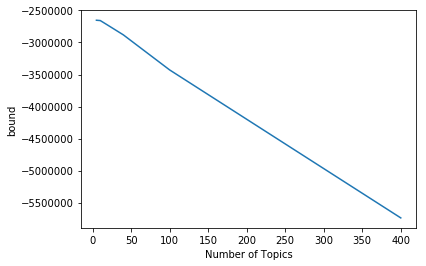

In [205]:
plt.plot(Ts, bound_bow)
plt.xlabel('Number of Topics')
plt.ylabel('bound')
plt.savefig('bow_bound_T_200.png')

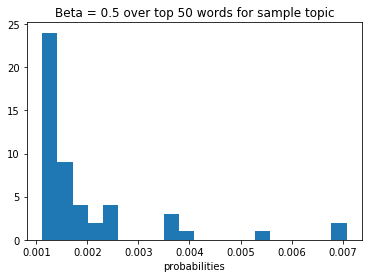

In [100]:
a = []
for x in bow_models[2].get_topic_terms(topicid=3, topn=50):
    a.append(x[-1])
plt.hist(a, bins=20)
plt.xlabel('probabilities')
plt.title('Beta = 0.5 over top 50 words for sample topic')
plt.savefig('beta2_hist.png')

In [ ]:
bow_model = gensim.models.LdaMulticore(bow_corpus, 
                                   num_topics = 20, 
                                   id2word = dictionary,                                    
                                   passes = 2,
                                   workers = 2)

In [ ]:
for idx, topic in bow_model.print_topics(-1):
    print('Topic: {} \nWords: {}'.format(idx, topic))

In [ ]:
# Compute Perplexity
print('\nPerplexity: ', bow_model.log_perplexity(bow_corpus))  # a measure of how good the model is. lower the better.

## TFIDF Model

In [169]:
#model generated from tfidf matrix
Ts = [5, 10, 20, 40, 100, 400]
perp_tfidf = []

for T in tqdm(Ts):
    tfidf_model = gensim.models.LdaMulticore(corpus_tfidf, 
                                   num_topics = T, 
                                   id2word = dictionary,                                    
                                   passes = 2,
                                   workers = 2)
    #bow_models.append(bow_model)
#     print('For beta = ' + str(beta))
#     for idx, topic in bow_model.print_topics(-1):
#         print('Topic: {} \nWords: {}'.format(idx, topic))
    perp_tfidf.append(tfidf_model.log_perplexity(bow_corpus))



/Users/erenaldis/anaconda/lib/python3.6/site-packages/gensim/models/ldamodel.py:1024: RuntimeWarning: divide by zero encountered in log
  diff = np.log(self.expElogbeta)


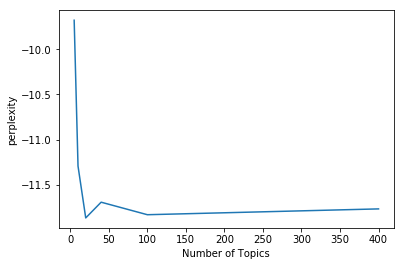

In [170]:
plt.plot(Ts, perp_tfidf)
plt.xlabel('Number of Topics')
plt.ylabel('perplexity')
plt.savefig('TFIDF_perplexity_T200.png')

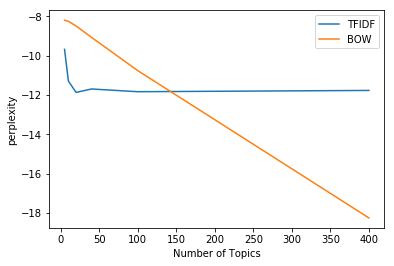

In [171]:
plt.plot(Ts, perp_tfidf, label='TFIDF')
plt.plot(Ts, perp_bow, label='BOW')
plt.xlabel('Number of Topics')
plt.ylabel('perplexity')
plt.legend()
plt.savefig('bow_TFIDF_perplexity_T200.png')

In [ ]:
for idx, topic in tfidf_model.print_topics(-1):
    print('Topic: {} \nWords: {}'.format(idx, topic))

In [ ]:
# Compute Perplexity
print('\nPerplexity: ', tfidf_model.log_perplexity(bow_corpus))  # a measure of how good the model is. lower the better.

In [141]:
perp_bow, perp_tfidf

([-9.313715851695912,
  -9.265478339205933,
  -9.316512909580824,
  -9.456639207076496,
  -10.127164542096661,
  -13.932216066989929],
 [-10.506847009409821,
  -11.378412961874053,
  -12.35826575140395,
  -12.449411760154462,
  -12.342853828928666,
  -12.481766169272545])

In [144]:
max(perp_bow), Ts[1]

(-9.265478339205933, 10)

In [173]:
perp_bow, perp_tfidf

([-8.193665157451203,
  -8.248157254814844,
  -8.485802952966862,
  -9.06628657272123,
  -10.759759098611942,
  -18.262216997807297],
 [-9.67644926006385,
  -11.294297517014389,
  -11.86914698421371,
  -11.694747298789805,
  -11.833652488003338,
  -11.769091087674564])

In [174]:
max(perp_bow), Ts[1]

(-8.193665157451203, 10)

## Choose the BOW Model with Optimal Params

In [256]:
T = 10
bow_model = gensim.models.LdaMulticore(bow_corpus, 
                                   num_topics = T, 
                                   id2word = dictionary,                                    
                                   passes = 4,
                                   workers = 2)


In [317]:
# Visualize the topics
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(bow_model, bow_corpus, dictionary)
vis

PreparedData(topic_coordinates=            Freq  cluster  topics         x         y
topic                                                
1      14.363733        1       1  0.048608  0.025211
8      12.389397        1       2  0.036789 -0.009712
7      11.145665        1       3 -0.060033 -0.092936
3      10.631675        1       4 -0.054605 -0.017561
9       9.274907        1       5 -0.004671  0.003525
4       8.743596        1       6  0.098423  0.019805
5       8.688834        1       7 -0.136509  0.100404
2       8.579470        1       8  0.020933 -0.098624
6       8.488112        1       9 -0.020158 -0.015910
0       7.694611        1      10  0.071223  0.085798, topic_info=     Category         Freq       Term        Total  loglift  logprob
term                                                                
780   Default  1965.000000       dick  1965.000000  30.0000  30.0000
1937  Default  1074.000000        sam  1074.000000  29.0000  29.0000
4373  Default   818.000000      byron   818.000000  28.0000  28.0000
2919  Default  1081.000000        dan  1081.000000  27.0000  27.0000
4165  Default   621.000000    builder   621.000000  26.0000  26.0000
874   Default   614.000000  formation   614.000000  25.0000  25.0000
432   Default   672.000000   margaret   672.000000  24.0000  24.0000
78    Default   840.000000       jone   840.000000  23.0000  23.0000
3525  Default   425.000000       gore   425.000000  22.0000  22.0000
3527  Default   513.000000      helen   513.000000  21.0000  21.0000
1763  Default   556.000000       jane   556.000000  20.0000  20.0000
4405  Default   410.000000     murray   410.000000  19.0000  19.0000
3087  Default   918.000000      roger   918.000000  18.0000  18.0000
1375  Default   580.000000   footnote   580.000000  17.0000  17.0000
2954  Default   452.000000   felicity   452.000000  16.0000  16.0000
3364  Default   415.000000      tommy   415.000000  15.0000  15.0000
2654  Default   450.000000     venice   450.000000  14.0000  14.0000
3277  Default   323.000000     bounce   323.000000  13.0000  13.0000
1272  Default   309.000000       torn   309.000000  12.0000  12.0000
2885  Default   379.000000      billy   379.000000  11.0000  11.0000
763   Default   285.000000      daisy   285.000000  10.0000  10.0000
224   Default   378.000000    slavery   378.000000   9.0000   9.0000
338   Default   375.000000       eddy   375.000000   8.0000   8.0000
3822  Default   440.000000   spaniard   440.000000   7.0000   7.0000
3408  Default   734.000000        ben   734.000000   6.0000   6.0000
2599  Default   342.000000        tar   342.000000   5.0000   5.0000
898   Default   349.000000     greece   349.000000   4.0000   4.0000
3537  Default   476.000000   lordship   476.000000   3.0000   3.0000
2423  Default   520.000000   monsieur   520.000000   2.0000   2.0000
4312  Default   308.000000   benjamin   308.000000   1.0000   1.0000
...       ...          ...        ...          ...      ...      ...
3425  Topic10    39.463785        cot    90.741588   1.7320  -6.4541
3833  Topic10    16.243461    firearm    37.914192   1.7170  -7.3417
481   Topic10    52.520504    prairie   125.710722   1.6919  -6.1682
420   Topic10    36.693919     kitten    91.261482   1.6535  -6.5268
3405  Topic10    27.081930  battalion    67.579927   1.6502  -6.8306
4454  Topic10    51.377528      yacht   129.003819   1.6440  -6.1902
1085  Topic10    18.009483     pickle    45.890392   1.6293  -7.2385
1028  Topic10    92.965008      motor   237.592618   1.6263  -5.5972
2667  Topic10    16.681235      whack    42.865447   1.6209  -7.3152
2974  Topic10    71.854605        git   185.231934   1.6177  -5.8548
4458  Topic10    23.282560  brushwood    60.063860   1.6169  -6.9817
3250  Topic10    33.954429    foreman    88.712109   1.6043  -6.6044
4052  Topic10    83.714987        von   226.853340   1.5678  -5.7020
2898  Topic10    87.850200       chum   238.619056   1.5654  -5.6538
24    Topic10    76.401842        dat   209.917183   1.5539  -5.79

# Gibbs Sampling Based Model

In [176]:
import lda as lda_gibbs

In [200]:
loglik_gibbs = []
for T in Ts[:-1]:
    gibbs_model = lda_gibbs.LDA(n_topics=T, n_iter=1500, random_state=1)
    gibbs_model.fit(dtm.astype(int))
    loglik_gibbs.append(gibbs_model.loglikelihood()/len(dictionary))

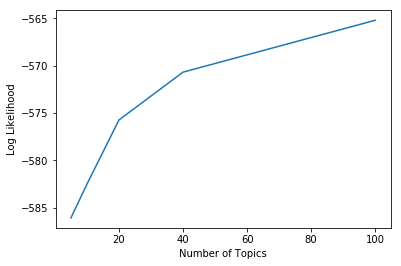

In [202]:

plt.plot(Ts[:-1], loglik_gibbs)
plt.xlabel('Number of Topics')
plt.ylabel('Log Likelihood')
plt.savefig('Gibbs_perplexity_T200.png')

In [210]:
gibbs_model = lda_gibbs.LDA(n_topics=10, n_iter=1500, random_state=1)
gibbs_model.fit(dtm.astype(int))
gibbs_model.components_.shape

(10, 4570)

In [215]:
aic= []
voc = 4570

for i in range(len(loglik_gibbs)):
    aic.append(-loglik_gibbs[i] + 2*voc*Ts[i])

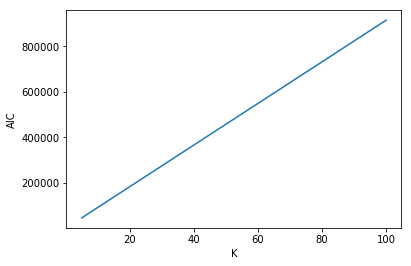

In [314]:
plt.plot(Ts[:-1],aic)
plt.xlabel("K")
plt.ylabel('AIC')
plt.savefig('Gibbs_AIC_T200.png')

In [318]:
topic_word = gibbs_model.topic_word_  # model.components_ also works
n_top_words = 10
vocab = list(dictionary.values())
topics = []
for i, topic_dist in enumerate(topic_word):
    topic_words = np.array(vocab)[np.argsort(topic_dist)][:-(n_top_words+1):-1]
    topics.append('Topic {}: {}'.format(i, ' '.join(topic_words)))
    print('Topic {}: {}'.format(i, ' '.join(topic_words)))

Topic 0: roger tar orchard ben chum der grandmother sam senator kid
Topic 1: jone donkey hillside martin someone fir query buffalo mare sergeant
Topic 2: jane madame helen monsieur walter benjamin michael guy david mamma
Topic 3: lordship murray slavery eddy lincoln negro anti carlyle director republican
Topic 4: margaret ben center ballad myth vol cambridge baker homer walter
Topic 5: formation fig slate thickness pebble granite layer jean volcanic loop
Topic 6: dick dan sam builder billy felicity tommy skipper bounce wot
Topic 7: venice republic monk barber villa balcony olive ugh oar neighborhood
Topic 8: gore fort canoe camel spaniard cavalry arab trader ruby waggon
Topic 9: byron hath footnote hast earl duchess persian cardinal wilt athen


In [ ]:
(lda_gibbs_model.loglikelihood()/len(dictionary))

In [219]:
gibbs_model = lda_gibbs.LDA(n_topics=10, n_iter=1500, random_state=1)
gibbs_model.fit(dtm.astype(int))

In [221]:
from sklearn.decomposition import PCA
pca =PCA(n_components=2)
tr = pca.fit_transform(gibbs_model.components_)

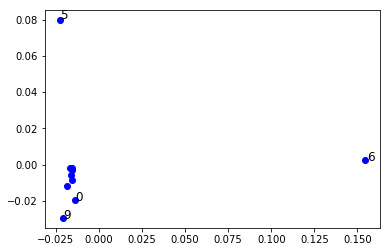

In [226]:
for i in range(len(tr)):
    x = tr[i, 0]
    y = tr[i, 1]
    plt.plot(x, y, 'bo')
    if (i == 0) or (i == 6) or (i==9) or (i==5):
        plt.text(x * (1 + 0.01), y * (1 + 0.01) , i, fontsize=12)
plt.savefig('Topic_Distr_Gibbs.png')

In [316]:
gibbs_model.components_.shape

(10, 4570)

# Clustering Documents Together by Topic Distributions

In [220]:
from scipy.spatial.distance import jensenshannon

In [306]:
gibbs_distances= []
for i in range(1, len(gibbs_model.doc_topic_)):
    gibbs_distances.append(jensenshannon(gibbs_model.doc_topic_[42, :],gibbs_model.doc_topic_[i, :]))

In [310]:
np.where(fclust3 == 42)[0]
for i in np.where(fclust3 == 42)[0]:
    print(list(corpus.keys())[i])

gutenberg/txt/Anthony Trollope___The Chateau of Prince Polignac.txt
gutenberg/txt/Joseph Conrad___The Arrow of Gold.txt


In [276]:
fclust3 = fclusterdata(prob_matrix 1.0, metric='mahalanobis')


In [290]:
from sklearn.metrics import davies_bouldin_score
davies_bouldin_score(prob_matrix,fclust1 ), davies_bouldin_score(gibbs_model.doc_topic_,fclust2 )

/Users/erenaldis/anaconda/lib/python3.6/site-packages/sklearn/metrics/cluster/unsupervised.py:342: RuntimeWarning: divide by zero encountered in true_divide
  score = (intra_dists[:, None] + intra_dists) / centroid_distances
/Users/erenaldis/anaconda/lib/python3.6/site-packages/sklearn/metrics/cluster/unsupervised.py:342: RuntimeWarning: invalid value encountered in true_divide
  score = (intra_dists[:, None] + intra_dists) / centroid_distances
/Users/erenaldis/anaconda/lib/python3.6/site-packages/sklearn/metrics/cluster/unsupervised.py:342: RuntimeWarning: divide by zero encountered in true_divide
  score = (intra_dists[:, None] + intra_dists) / centroid_distances
/Users/erenaldis/anaconda/lib/python3.6/site-packages/sklearn/metrics/cluster/unsupervised.py:342: RuntimeWarning: invalid value encountered in true_divide
  score = (intra_dists[:, None] + intra_dists) / centroid_distances


(0.4954919170847478, 0.716160053609095)

In [288]:
fclust1, fclust2

(array([69, 64, 52, 58, 35, 52, 48, 52, 42, 52, 17, 72,  1, 61, 71,  8, 52,
        34, 52, 19, 35, 21, 52, 42, 36, 15, 58, 50, 23, 24, 14, 80, 34, 44,
        11, 16, 42, 52, 16, 56, 63, 50, 34,  6, 44, 52, 73, 52, 47, 51,  3,
        75,  8, 45, 15, 52, 71, 42, 15, 57, 15, 59, 16, 33,  2, 37, 42, 43,
        27, 42, 12, 58, 60, 71, 52,  4, 25, 79, 42, 15, 38, 83,  1, 52, 43,
         9, 43, 52, 81, 10, 49, 67, 78, 58, 45, 29, 86, 46, 53, 77, 52, 55,
        47, 52, 28, 53, 16,  7,  5, 31, 54, 44, 56, 13, 87, 39, 23, 54,  2,
        52, 50, 70, 22,  7,  2, 15, 58, 58, 55, 49, 48, 50, 72, 51, 32, 88,
        54, 14, 71, 40, 50, 57, 46, 52, 51, 33, 30,  6, 50, 42, 15, 34, 65,
        42,  6, 42, 74, 37, 15, 51, 52, 22, 76, 21, 70, 15, 71, 26, 66, 48,
        62, 84,  3, 18, 85, 57, 59, 20, 72, 44, 58, 41, 24, 82, 68, 42, 50],
       dtype=int32),
 array([29, 41, 28, 49, 16, 21, 30, 62, 10, 17, 54, 42,  1, 60,  5, 76, 28,
        58, 78, 20, 75, 25, 30, 28, 11, 56, 29,  7, 57, 61, 23,  6

In [287]:
from scipy.cluster.hierarchy import fclusterdata
def jensenshannon_(p, q):
    return jensenshannon(p, q)

fclust1 = fclusterdata(prob_matrix, 1.0, metric=jensenshannon_)
fclust2 = fclusterdata(gibbs_model.doc_topic_, 1.0, metric=jensenshannon_)

In [311]:
print(list(corpus.keys())[42])
for k in np.argsort(bow_lda_distances)[:10]:
    print(list(corpus.keys())[k+1]), print(bow_lda_distances[k])

gutenberg/txt/Charles Darwin___Geological Observations On South America.txt
gutenberg/txt/Charles Darwin___Geological Observations On South America.txt
0.10883023148760229
gutenberg/txt/Sir Francis Galton___Finger Prints.txt
0.3133526426434082
gutenberg/txt/John Ruskin___The Elements of Drawing.txt
0.49991725634963563
gutenberg/txt/Thomas Henry Huxley___The Present Condition of Organic Nature.txt
0.5618510896350042
gutenberg/txt/R M Ballantyne___Handbook to the new Gold-fields.txt
0.5842247755358079
gutenberg/txt/Thomas Carlyle___History of Friedrich II of Prussia, Appendix.txt
0.5884066512391625
gutenberg/txt/Sir Richard Francis Burton___The Land of Midian, Volume 2.txt
0.5973719728078024
gutenberg/txt/Louisa May Alcott___Behind A Mask, Or A Woman's Power.txt
0.6293273754803962
gutenberg/txt/Rudyard Kipling___With The Night Mail.txt
0.6924695954761101
gutenberg/txt/Thomas Henry Huxley___The Darwinian Hypothesis.txt
0.7151296872989737


In [302]:
bow_lda_distances= []
for i in range(1, len(prob_matrix)):
    bow_lda_distances.append(jensenshannon(prob_matrix[42, :] ,gibbs_model.doc_topic_[i, :] ))

In [258]:
prob_matrix = np.zeros((len(bow_corpus), T))
for i in range(len(bow_corpus)): 
    probs = []
    keys = []
    for tup in bow_model.get_document_topics(bow_corpus[i], minimum_probability=0 ):
        probs.append(tup[-1])
    prob_matrix[i, :] = probs

In [313]:
print(list(corpus.keys())[42])
for k in np.argsort(gibbs_distances)[:10]:
    print(list(corpus.keys())[k+1]), print(gibbs_distances[k])

gutenberg/txt/Charles Darwin___Geological Observations On South America.txt
gutenberg/txt/Charles Darwin___Geological Observations On South America.txt
0.0
gutenberg/txt/Sir Francis Galton___Finger Prints.txt
0.25644256061361426
gutenberg/txt/John Ruskin___The Elements of Drawing.txt
0.4461337942157081
gutenberg/txt/Thomas Henry Huxley___The Present Condition of Organic Nature.txt
0.5123696892283027
gutenberg/txt/R M Ballantyne___Handbook to the new Gold-fields.txt
0.5286274854897121
gutenberg/txt/Sir Richard Francis Burton___The Land of Midian, Volume 2.txt
0.5479647217353617
gutenberg/txt/Thomas Carlyle___History of Friedrich II of Prussia, Appendix.txt
0.5490317894212112
gutenberg/txt/Louisa May Alcott___Behind A Mask, Or A Woman's Power.txt
0.6060439720746252
gutenberg/txt/Rudyard Kipling___With The Night Mail.txt
0.6428877945486855
gutenberg/txt/Thomas Henry Huxley___The Darwinian Hypothesis.txt
0.6717541074848006


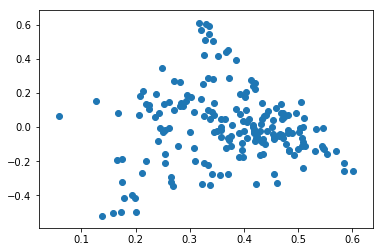

In [235]:
plt.scatter(x, y)

In [231]:
gibbs_model.doc_topic_.shape

(187, 10)

In [234]:
# Construct the k-means clusters
from sklearn.cluster import KMeans
clusters = KMeans(n_clusters=15, random_state=100).fit_predict(gibbs_model.doc_topic_)

from sklearn.decomposition import TruncatedSVD
# Build the Singular Value Decomposition(SVD) model
svd_model = TruncatedSVD(n_components=2)  # 2 components
lda_output_svd = svd_model.fit_transform(gibbs_model.doc_topic_)

# X and Y axes of the plot using SVD decomposition
x = lda_output_svd[:, 0]
y = lda_output_svd[:, 1]

# Weights for the 15 columns of lda_output, for each component
print("Component's weights: \n", np.round(svd_model.components_, 2))

# Percentage of total information in 'lda_output' explained by the two components
print("Perc of Variance Explained: \n", np.round(svd_model.explained_variance_ratio_, 2))

Component's weights: 
 [[ 0.12  0.71  0.27  0.31  0.12  0.05  0.12  0.48  0.19  0.11]
 [-0.18 -0.35 -0.02  0.69  0.12  0.06 -0.53  0.24 -0.08  0.08]]
Perc of Variance Explained: 
 [0.06 0.22]


In [301]:
c=0
for i in list(corpus.keys()):
    
    if 'gutenberg/txt/Charles Darwin___Geological Observations On South America.txt' == i:
        print(c)
    c+=1

42


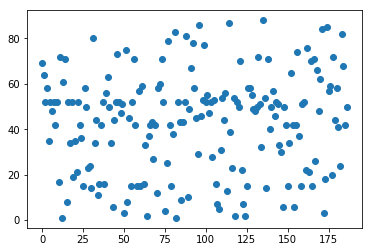

In [274]:
plt.scatter(range(len(fclust1)), fclust1)

In [320]:
fclust3[42]

2

In [327]:
for i in np.where(fclust3 == 2)[0]:
    print(list(corpus.keys())[i])

gutenberg/txt/James Fenimore Cooper___The Redskins; or, Indian and Injin, Volume 1.txt
gutenberg/txt/Charles Darwin___Geological Observations On South America.txt


In [326]:
list(corpus.keys())[42]

'gutenberg/txt/Charles Darwin___Geological Observations On South America.txt'